# Data Reading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from backtesting import Strategy
from backtesting.lib import crossover
from backtesting import Backtest

In [2]:
df_ohlc=pd.read_csv('data/BinanceTop10Raw.csv',header=[0, 1],index_col=0)
df_ohlc.index=pd.DatetimeIndex(df_ohlc.index)
df_Close=df_ohlc.swaplevel(axis=1)['Close']

Spliting the data to test, train

In [3]:
df_train,df_validate,df_test=df_ohlc.loc[:'2022-01-01'],df_ohlc.loc['2022-01-01':'2022-09-01'],df_ohlc.loc['2022-09-01':]

# Predicting Market Movements with Hull Moving Averge

First we define an empty dataframe to contain the return of the strategy for each coin

In [4]:
HMA_Returns_trained=pd.DataFrame()
HMA_Returns_test=pd.DataFrame()

we need to define some functions to use

In [5]:
def WMA(data,period):
    """Weighted Moving Average (WMA) a technical indicator

    Args:
        data (Series).
        period (int): length.

    Returns:
        Series: Seires with WMA values 
    """
    
    data=pd.Series(data)
    return data.rolling(period).apply(lambda x: ((np.arange(period)+1)*x).sum()/(np.arange(period)+1).sum(), raw=True)
    
def HMA(data,period):
    """Hull Moving Average (HMA) a technical indicator

    Args:
        data (Series).
        period (int): length.

    Returns:
        Series: Seires with HMA values 
    """
    return WMA((WMA(data, period//2)*2)-(WMA(data, period)), int(np.sqrt(period)))

## Backtesting.py


Next we will use `backtesting.py` library to backtest, optimise and exctract returns from

### Strategy definition

In [6]:
class Hma_start(Strategy):
    # Define the two MA lags as *class variables*
    # for later optimization
    n1 = 45
    n2 = 200
    n3 = 30
    def init(self):
        # Precompute the two moving averages
        self.ma1 = self.I(HMA, self.data.Close, self.n1,plot=False)
        self.ma2 = self.I(HMA, self.data.Close, self.n2,plot=False)
        self.ma3 = self.I(HMA, self.data.Close, self.n3)
    def next(self):

        if crossover(self.ma1, self.ma2) and not self.position.is_long :
            tp,sl= self.data.Close[-1] * (1 + np.r_[.5, -.02])
            self.buy(tp=tp, sl=sl)    
        elif crossover(self.ma2, self.ma1) and not self.position.is_short:
            tp,sl= self.data.Close[-1] * (1 + np.r_[-.5, 0.02])
            self.sell(tp=tp, sl=sl)
        current_time = self.data.index[-1]
        for trade in self.trades:
            if current_time - trade.entry_time > pd.Timedelta('1 days'):
                # if trade.is_long:
                    trade.sl = max(trade.sl, trade.entry_price)
                # else:
                #     trade.sl = min(trade.sl, self.data.entry_price)


### Traning the HMA model

We will train the model from 2020 to 2022-9-1, optimizing n1 and n2 on the Sharpe Ratio in that period.

In [7]:
def Metric_to_optimse(series):
    return series['Sharpe Ratio']

In [8]:
instruments=df_ohlc.columns.get_level_values(0).unique()
parameters={}

for instrument in instruments:
    data = df_train[instrument]
    bt = Backtest(data, Hma_start , cash=1000000)
    stats = bt.optimize(n1=range(30, 300, 20),
                        n2=range(30, 300, 20),
                        maximize=Metric_to_optimse,
                        method='skopt',
                        constraint=lambda param: param.n1 < param.n2,
                        max_tries=800,
                        )
    HMA_Returns_trained[instrument]=stats._equity_curve.Equity/1000000
    params={'n1':stats._strategy.n1,'n2':stats._strategy.n2}
    parameters[instrument]=params
parameters

    

{'BTCUSDT': {'n1': 56, 'n2': 135},
 'ETHUSDT': {'n1': 70, 'n2': 144},
 'BNBUSDT': {'n1': 45, 'n2': 211},
 'BUSDUSDT': {'n1': 102, 'n2': 105},
 'XRPUSDT': {'n1': 250, 'n2': 288},
 'DOGEUSDT': {'n1': 220, 'n2': 266},
 'ADAUSDT': {'n1': 223, 'n2': 227},
 'MATICUSDT': {'n1': 262, 'n2': 275},
 'DOTUSDT': {'n1': 139, 'n2': 145},
 'LTCUSDT': {'n1': 81, 'n2': 289}}

We also assigned the optimal parameters to `parameters` so that we can test the results on 

In [9]:
for instrument in instruments:
    bt=Backtest(df_validate[instrument], Hma_start , cash=1000000)
    stats=bt.run(**parameters[instrument])
    HMA_Returns_test[instrument]=stats._equity_curve.Equity/1000000

In [10]:
stats

Start                     2022-01-01 00:00:00
End                       2022-09-01 18:00:00
Duration                    243 days 18:00:00
Exposure Time [%]                   20.901639
Equity Final [$]                  1594616.428
Equity Peak [$]                   1669059.428
Return [%]                          59.461643
Buy & Hold Return [%]              -61.120864
Return (Ann.) [%]                   100.98044
Volatility (Ann.) [%]               72.165973
Sharpe Ratio                         1.399281
Sortino Ratio                        6.821027
Calmar Ratio                        10.659129
Max. Drawdown [%]                   -9.473611
Avg. Drawdown [%]                   -3.688108
Max. Drawdown Duration       86 days 00:00:00
Avg. Drawdown Duration        8 days 17:00:00
# Trades                                    5
Win Rate [%]                             40.0
Best Trade [%]                       49.95614
Worst Trade [%]                     -2.139403
Avg. Trade [%]                    

Row(id='1371', ...)

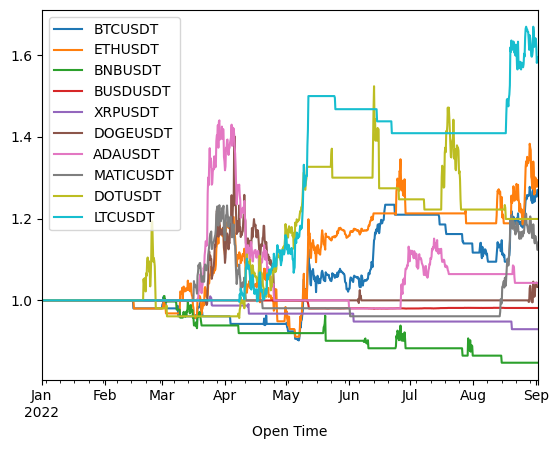

In [11]:
HMA_Returns_test.plot()
bt.plot()

In [13]:
HMA_Returns_test.iloc[-1].mean()


1.1314392776535998

In [14]:
HMA_Returns_trained.to_csv('ModelsResult/OptimizedHMA_trained.csv')
HMA_Returns_test.to_csv('ModelsResult/OptimizedHMA_test.csv')
parameters

{'BTCUSDT': {'n1': 56, 'n2': 135},
 'ETHUSDT': {'n1': 70, 'n2': 144},
 'BNBUSDT': {'n1': 45, 'n2': 211},
 'BUSDUSDT': {'n1': 102, 'n2': 105},
 'XRPUSDT': {'n1': 250, 'n2': 288},
 'DOGEUSDT': {'n1': 220, 'n2': 266},
 'ADAUSDT': {'n1': 223, 'n2': 227},
 'MATICUSDT': {'n1': 262, 'n2': 275},
 'DOTUSDT': {'n1': 139, 'n2': 145},
 'LTCUSDT': {'n1': 81, 'n2': 289}}